In [10]:
import os
import json

from ultralytics import YOLO

from glob import glob
from tqdm import tqdm

In [8]:
# config

model = YOLO("yolov8s.pt")
images = 'data/bdd100k/images/'
subsets = ['train', 'val', 'test']
save = 'data/bdd100k/labels_yolov8s'


In [11]:
# YOLO 객체를 BDD100K JSON 형식으로 변환

def convert_yolo_to_bdd(result, img_path):
    objects = []

    for i, box in enumerate(result.boxes):
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        cls_name = result.names[int(box.cls)]

        objects.append({
            "id": i,
            "category": cls_name,
            "attributes": {},
            "box2d": {
                "x1": float(x1),
                "y1": float(y1),
                "x2": float(x2),
                "y2": float(y2)
            }
        })

    return {
        "name": os.path.basename(img_path),
        "frames": [{
            "timestamp": 0,
            "objects": objects
        }],
        "attributes": {}
    }


# 반복 처리
for subset in subsets:
    img_paths = glob(os.path.join(images, subset, "*.jpg"))
    save_subset = os.path.join(save, subset)
    os.makedirs(save_subset, exist_ok=True)

    print(f"\n📂 Processing '{subset}' set ({len(img_paths)} images)...")

    for img_path in tqdm(img_paths):
        result = model(img_path, verbose=False)[0]  # YOLO 추론 (silent mode)
        json_data = convert_yolo_to_bdd(result, img_path)

        save_path = os.path.join(
            save_subset,
            os.path.splitext(os.path.basename(img_path))[0] + ".json"
        )

        with open(save_path, "w") as f:
            json.dump(json_data, f, indent=4)

print("\n🎯 Done! 객체 라벨 생성 완료.")
print(f"📍 저장 위치: {save}")


📂 Processing 'train' set (1400 images)...


100%|██████████| 1400/1400 [02:15<00:00, 10.37it/s]



📂 Processing 'val' set (200 images)...


100%|██████████| 200/200 [00:18<00:00, 10.68it/s]



📂 Processing 'test' set (400 images)...


100%|██████████| 400/400 [00:41<00:00,  9.67it/s]


🎯 Done! 객체 라벨 생성 완료.
📍 저장 위치: data/bdd100k/labels_yolov8s


## Image Validation

In [18]:
import os
import json
import random
import cv2
import time
import matplotlib.pyplot as plt

In [13]:
# config
image_root = "data/bdd100k/images/"
json_root = "data/bdd100k/labels_yolov8s/"
subset = "train"  # 또는 'val', 'test'
num_samples = 5   # 랜덤 선택할 개수

In [25]:
def samples(json_root, subset, num_samples):
    json_files = [
        os.path.join(json_root, subset, f)
        for f in os.listdir(os.path.join(json_root, subset))
        if f.endswith(".json")
    ]
    random.seed(time.time())
    sample_files = random.sample(json_files, num_samples)

    print(f"🎯 랜덤 선택된 JSON 파일 {num_samples}개:")
    for f in sample_files:
        print(" -", os.path.basename(f))
        
    return sample_files

In [23]:
# 시각화 함수
def visualize_bdd_json(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    img_name = data["name"]
    img_path = os.path.join(image_root, subset, img_name)

    # 이미지 불러오기
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ 이미지 없음: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 7))
    plt.imshow(img)
    ax = plt.gca()

    # 객체 출력
    for obj in data["frames"][0]["objects"]:
        if "box2d" not in obj:
            continue

        x1 = obj["box2d"]["x1"]
        y1 = obj["box2d"]["y1"]
        x2 = obj["box2d"]["x2"]
        y2 = obj["box2d"]["y2"]

        category = obj["category"]

        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, category, color="yellow", fontsize=10)

    plt.title(f"{img_name} (from {subset})")
    plt.axis("off")
    plt.show()




🎯 랜덤 선택된 JSON 파일 5개:
 - 014c3c65-3e7539a0.json
 - 002d290d-fa2a8964.json
 - 039cb0e4-4dbb3be1.json
 - 02504d95-8ede0c80.json
 - 036aea46-ee63a8e7.json


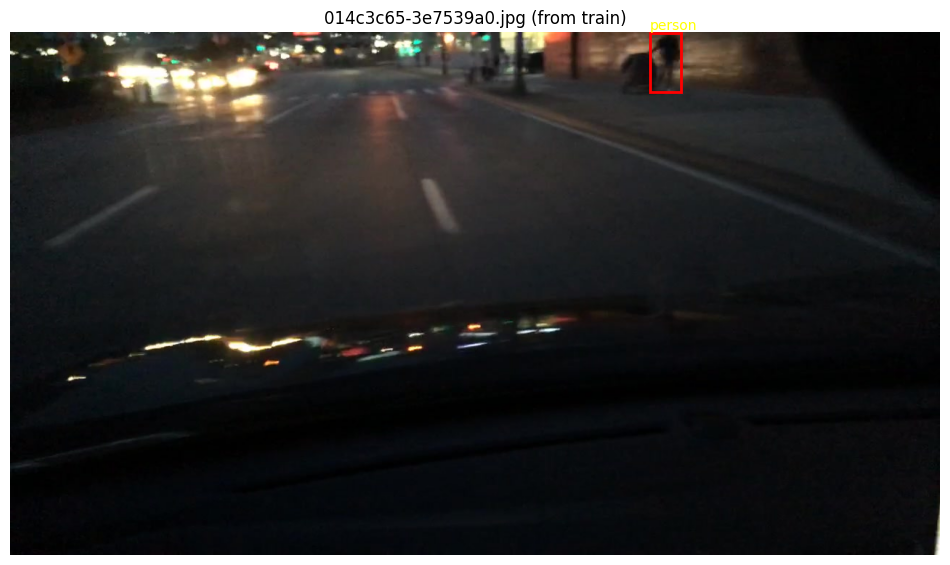

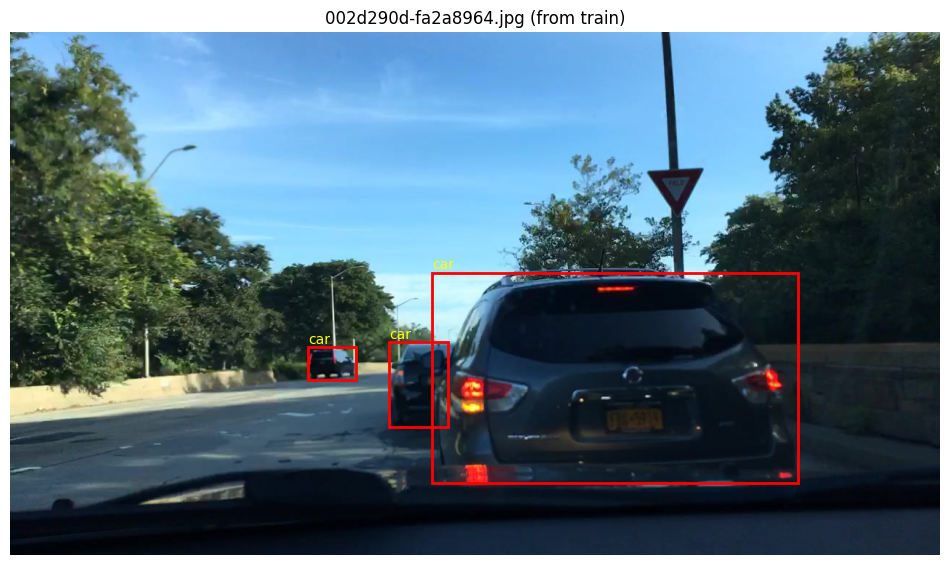

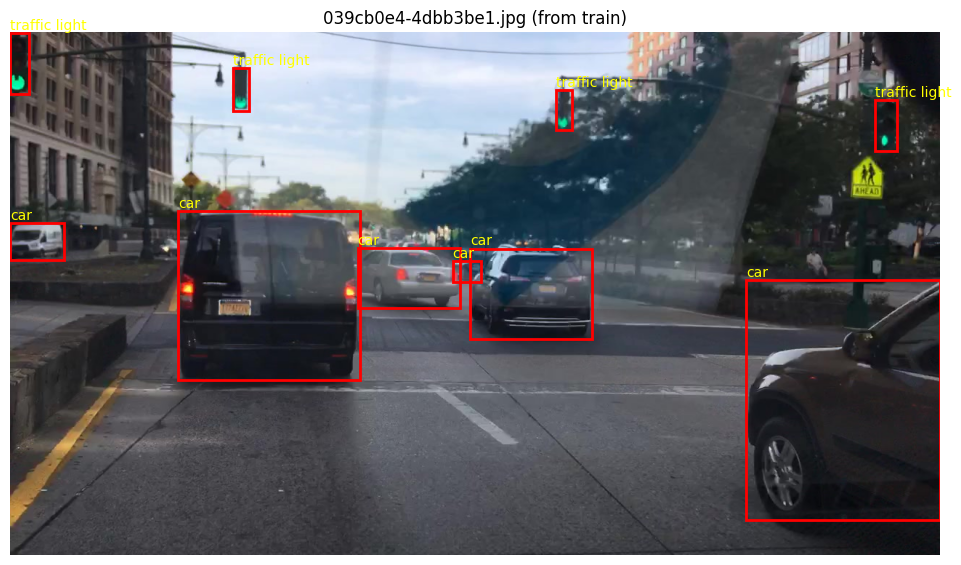

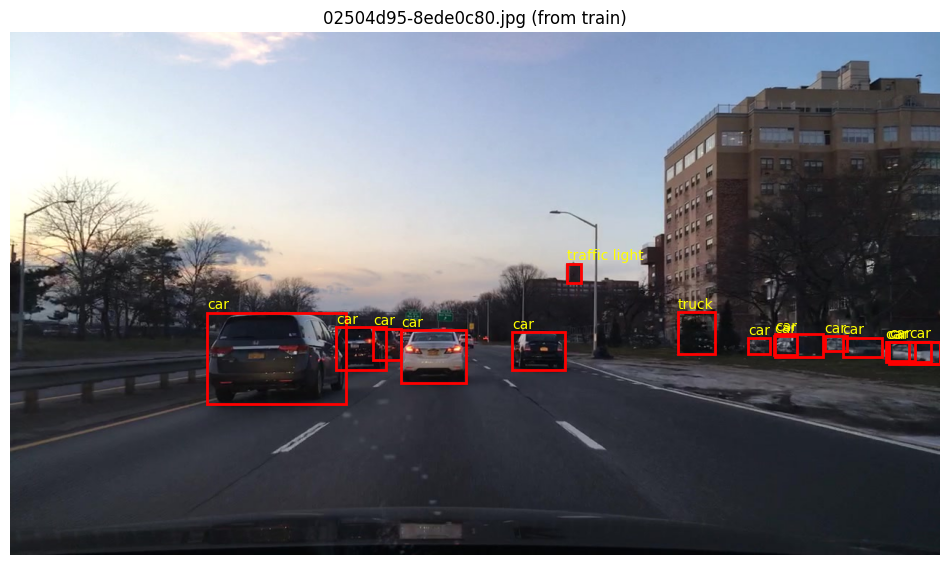

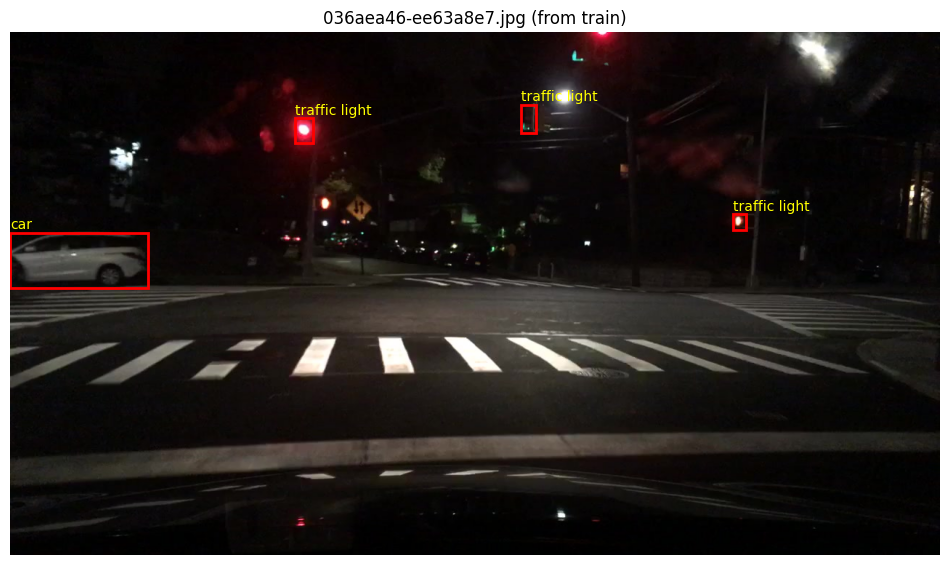

In [27]:
# 실행
for json_path in samples(json_root, subset, num_samples):
    visualize_bdd_json(json_path)

### Checking Object

In [28]:
import os
import json
from collections import Counter, defaultdict

In [29]:
json_root = "data/bdd100k/labels_yolov8s"  # 너가 json 저장한 루트
subsets = ["train", "val", "test"]         # 분석할 폴더


In [30]:
results = {}

for subset in subsets:
    subset_path = os.path.join(json_root, subset)
    obj_counter = Counter()

    if not os.path.exists(subset_path):
        print(f"⚠ 폴더 없음: {subset_path}")
        continue

    json_files = [f for f in os.listdir(subset_path) if f.endswith(".json")]

    print(f"\n📂 '{subset}' 폴더 JSON {len(json_files)}개 분석 중...")

    for jf in json_files:
        with open(os.path.join(subset_path, jf), "r") as f:
            data = json.load(f)

        # BDD100K JSON 구조 기준
        for obj in data["frames"][0]["objects"]:
            category = obj.get("category", "unknown")
            obj_counter[category] += 1

    results[subset] = obj_counter


📂 'train' 폴더 JSON 1400개 분석 중...

📂 'val' 폴더 JSON 200개 분석 중...

📂 'test' 폴더 JSON 400개 분석 중...


In [31]:
print("\n📊 객체(category)별 개수 합계\n")
for subset, counter in results.items():
    print(f"=== 📁 {subset} 폴더 ===")
    for category, count in counter.most_common():
        print(f"  {category:<20} → {count}")
    print("")


📊 객체(category)별 개수 합계

=== 📁 train 폴더 ===
  car                  → 7970
  traffic light        → 1692
  person               → 1172
  truck                → 591
  bus                  → 200
  stop sign            → 63
  motorcycle           → 40
  bicycle              → 34
  fire hydrant         → 27
  potted plant         → 14
  train                → 13
  umbrella             → 11
  bench                → 11
  handbag              → 8
  laptop               → 8
  backpack             → 7
  parking meter        → 6
  suitcase             → 4
  tv                   → 3
  chair                → 2
  mouse                → 2
  surfboard            → 1
  bird                 → 1
  cow                  → 1
  clock                → 1
  frisbee              → 1
  dog                  → 1
  tennis racket        → 1
  skateboard           → 1
  keyboard             → 1

=== 📁 val 폴더 ===
  car                  → 1116
  traffic light        → 253
  person               → 150
  truck             

In [32]:
save_md_path = "class_count_summary.md"
with open(save_md_path, "w", encoding="utf-8") as md:
    md.write("# 📊 YOLO 자동 라벨링 객체 개수 분석\n\n")
    md.write(f"**분석 기준 경로:** `{json_root}`\n\n")
    
    for subset, counter in results.items():
        md.write(f"## 📁 {subset} 폴더\n\n")
        md.write("| Category | Count |\n")
        md.write("|----------|-------|\n")
        
        for category, count in counter.most_common():
            md.write(f"| {category} | {count} |\n")
        
        md.write("\n---\n\n")

print(f"\n✅ Markdown 저장 완료 → `{save_md_path}`")


✅ Markdown 저장 완료 → `class_count_summary.md`


🎯 랜덤 5개 선택됨:
 ['03b106b5-c0e0b623.json', '00abd8a7-ecd6fc56.json', '03c239e4-158690bd.json', '030c8a82-4c8d6fb5.json', '03a3f4e9-262be322.json']
🔍 확인 중 → 03b106b5-c0e0b623.jpg


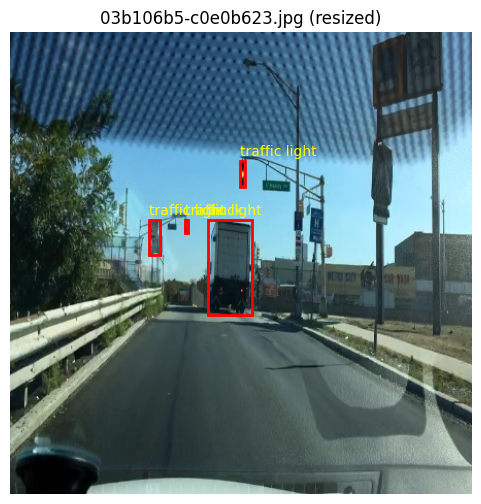

🔍 확인 중 → 00abd8a7-ecd6fc56.jpg


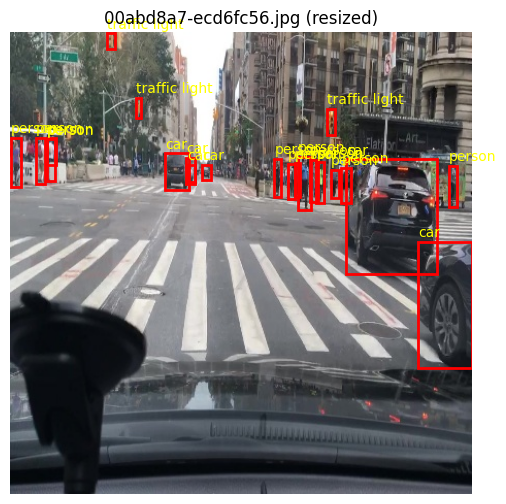

🔍 확인 중 → 03c239e4-158690bd.jpg


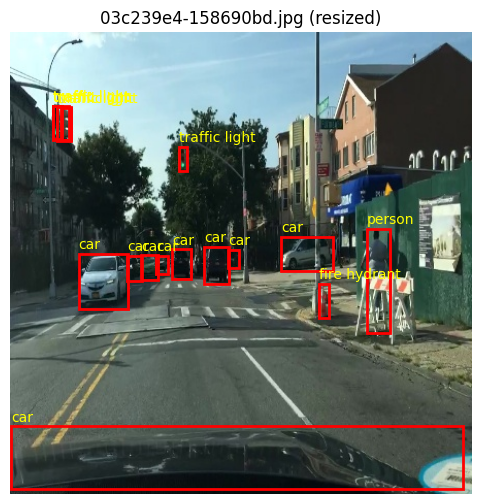

🔍 확인 중 → 030c8a82-4c8d6fb5.jpg


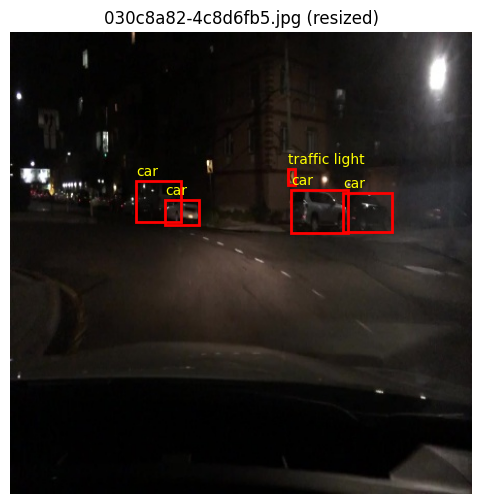

🔍 확인 중 → 03a3f4e9-262be322.jpg


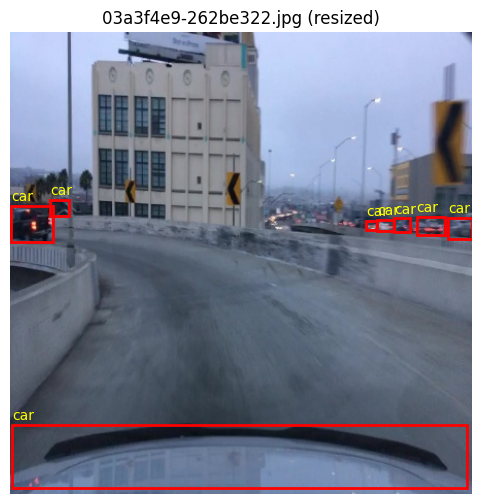

In [33]:
import os
import json
import random
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
image_root = "data/bdd100k/images_resized_448/"
json_root = "data/bdd100k/labels_resized_448/"
subset = "train"         # 또는 "val", "test"
num_samples = 5          # 랜덤 확인할 이미지 수

# 매 실행마다 다르게
random.seed()

# -----------------------------
# JSON 파일 랜덤 선택
# -----------------------------
json_files = [
    f for f in os.listdir(os.path.join(json_root, subset)) 
    if f.endswith(".json")
]

sample_files = random.sample(json_files, num_samples)
print(f"🎯 랜덤 {num_samples}개 선택됨:\n", sample_files)

# -----------------------------
# 시각화 함수
# -----------------------------
def visualize_image_with_json(img_path, json_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ 이미지 없음: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(json_path, "r") as f:
        data = json.load(f)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    ax = plt.gca()

    # bbox 그리기
    for obj in data["frames"][0]["objects"]:
        if "box2d" not in obj:
            continue
        
        x1 = obj["box2d"]["x1"]
        y1 = obj["box2d"]["y1"]
        x2 = obj["box2d"]["x2"]
        y2 = obj["box2d"]["y2"]
        category = obj["category"]

        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, category, color="yellow", fontsize=10)

    plt.title(f"{os.path.basename(img_path)} (resized)")
    plt.axis("off")
    plt.show()


# -----------------------------
# 실행
# -----------------------------
for json_file in sample_files:
    json_path = os.path.join(json_root, subset, json_file)
    img_name = os.path.splitext(json_file)[0] + ".jpg"
    img_path = os.path.join(image_root, subset, img_name)

    print(f"🔍 확인 중 → {img_name}")
    visualize_image_with_json(img_path, json_path)
